In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import cuda
import math

fulldata = pd.read_excel('hr1mono_shuf000.xlsx')
data = fulldata.loc[fulldata['enc'] > (10**19.4 / 10**18), :].reset_index()

/home/lucas/anaconda3/envs/cuda01/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  import sys


In [2]:
def alt_azi_to_RA_DEC(phi, a, A, t):
    sinDEC = np.sin(a) * np.sin(phi) + np.cos(a) * np.cos(phi) * np.cos(A)
    DEC = np.arcsin(sinDEC)

    sinH = -1 * np.sin(A) * np.cos(a) / np.cos(DEC)
    cosH = (np.sin(a) - np.sin(DEC) * np.sin(phi)) / (np.cos(DEC) * np.cos(phi))

    #values might be slightly outside of [-1, 1], this will fix that
    sinH[sinH > 1] = 1
    sinH[sinH < -1] = -1
    cosH[cosH > 1] = 1
    cosH[cosH < -1] = -1

    #I don't trust the principle value of arcsin to always be the correct H,
    #so, this will double check with the cos(H) values
    H = np.zeros(len(sinH))
    for i in range(len(sinH)):
        if abs(abs(np.arcsin(sinH[i])) - np.arccos(cosH[i])) < .001:
            H[i] = np.arcsin(sinH[i])
        else:
            H[i] = np.pi - np.arcsin(sinH[i])

    RA = np.mod(t * 15 - np.rad2deg(H), 360)
    return RA, np.rad2deg(DEC)


def RA_DEC_to_unit_vectors(RA, DEC):
    x = np.sin(np.deg2rad(90 - DEC)) * np.cos(np.deg2rad(-1 * RA))
    y = np.sin(np.deg2rad(90 - DEC)) * np.sin(np.deg2rad(-1 * RA))
    z = np.cos(np.deg2rad(90 - DEC))
    return np.array(np.array([x, y, z]).T)

def getparams():
    
    points = np.zeros((360*180,2), dtype='int32')
    for i in range(360):
        for j in range(-90, 90):
            points[j + 90 + i*180] = np.array([i, j])

    X2 = RA_DEC_to_unit_vectors(points[:, 0], points[:, 1])
    
    theta = np.cos(np.deg2rad(20))
    return points, X2, theta


#plots a rectangular color plot
def colorplot(localz, title):
    plt.figure(figsize = (10,5))
    plt.imshow(localz, origin='lower', extent = [0, 360, -90, 90])
    plt.xlabel('RA')
    plt.ylabel('DEC')
    plt.title(title)
    plt.colorbar()
    plt.show()

#plots a color plot with an aitoff projection
#I copied most of this online,
#https://stackoverflow.com/questions/49197997/project-numpy-array-to-aitoff-projection
#need to do something with the RA axis...
def aitoffcolorplot(localz, title):
    x = np.linspace(-np.pi,np.pi,localz.shape[1])
    y = np.linspace(-np.pi/2,np.pi/2,localz.shape[0])
    X,Y = np.meshgrid(x,y)
    
    plt.figure(figsize = (10,5))
    plt.subplot(111, projection="aitoff")

    plt.pcolormesh(X, Y[::-1], np.flip(np.roll(localz, 180, axis=1), axis = 0))
    plt.xlabel('RA')
    plt.ylabel('DEC')
    plt.tick_params(axis='x', colors='white')
    plt.title(title)
    plt.grid(True)
    plt.colorbar()
    plt.show()

In [3]:
@cuda.jit
def shufflesarray(localX1, localpoints, localX2, localZ):
    i = cuda.grid(1)
    for x2 in range(localX2.shape[0]):
        for x1 in range(localX1[i].shape[0]):
            if localX1[i, x1, 0]*localX2[x2, 0] + localX1[i, x1, 1]*localX2[x2, 1] + localX1[i, x1, 2]*localX2[x2, 2] > .939:
                localZ[localpoints[x2, 1] + 90, localpoints[x2, 0], i] += 1

In [4]:
%%time
phi = np.deg2rad(40.195203)
a = np.deg2rad(90 - data['zen'])
A = np.deg2rad(data['azi'])

iterations = 1000000
points, X2, theta = getparams()

meanz = np.zeros((180, 360, int(np.ceil(iterations/1000))))
squaredmeanz = np.zeros_like(meanz)
for i in range(int(np.ceil(iterations/1000))):

    Z = np.zeros((180, 360, 1000), dtype='int64')
    X1 = np.zeros((1000, len(data['sid']), 3))

    for j in range(1000):
        t = np.random.permutation(data['sid'].values)
        shufRA, shufDEC = alt_azi_to_RA_DEC(phi, a, A, t)
        X1[j] = RA_DEC_to_unit_vectors(shufRA, shufDEC)
        
    
    gpupoints = cuda.to_device(points)
    #gputheta = cuda.to_device(theta)
    gpuX2 = cuda.to_device(X2)
    gpuX1 = cuda.to_device(X1)
    gpuZ = cuda.to_device(Z)
    shufflesarray[128, int(np.ceil(1000/128))](gpuX1, gpupoints, gpuX2, gpuZ)

    meanz[:, :, i] = np.mean(gpuZ.copy_to_host(), axis = 2)
    squaredmeanz[:, :, i] = np.mean(gpuZ.copy_to_host() ** 2, axis = 2)
    del X1, Z
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

%%time
phi = np.deg2rad(40.195203)
a = np.deg2rad(90 - data['zen'])
A = np.deg2rad(data['azi'])

iterations = 1
points, X2, theta = getparams()
Z = np.zeros((180, 360, iterations), dtype='int32')
X1 = np.zeros((iterations, len(data['sid']), 3))
RA, DEC = alt_azi_to_RA_DEC(phi, a, A, data['sid'])
X1[0] = RA_DEC_to_unit_vectors(RA, DEC)
shufflesarray[128, int(np.ceil(iterations/128))](X1, points, X2, theta, Z)

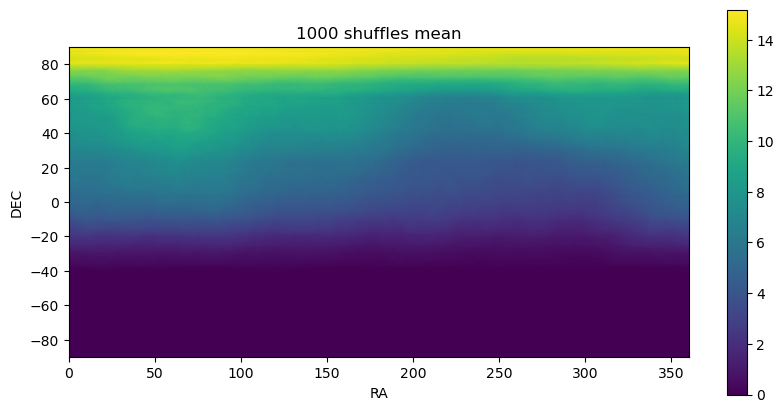

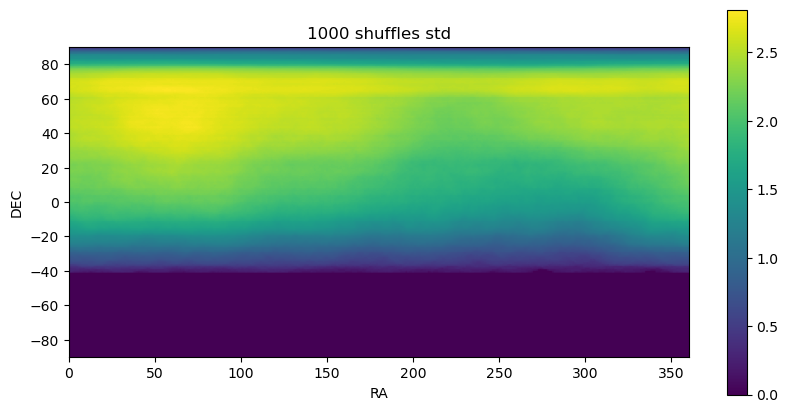

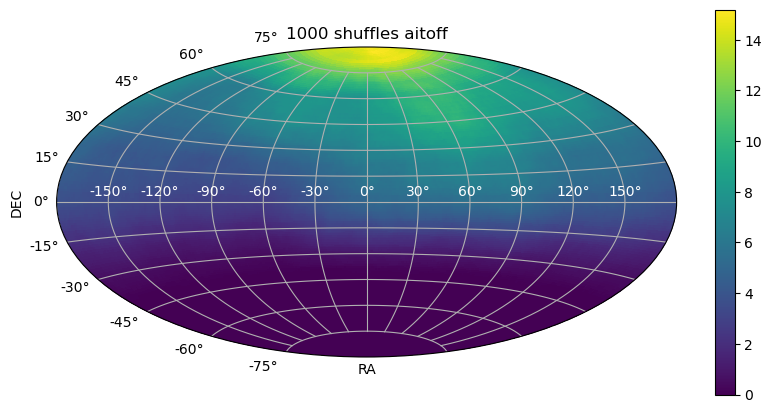

In [5]:
averageZ = np.mean(meanz, axis = 2)
averagesquaredZ = np.mean(squaredmeanz, axis = 2)
sigmaZ = np.sqrt(averagesquaredZ - averageZ ** 2)

meandf = pd.DataFrame(np.flip(averageZ, axis = 0))
sigmadf = pd.DataFrame(np.flip(sigmaZ, axis = 0))

meandf.to_csv('mean_1M', header = False, index = False)
sigmadf.to_csv('stdev_1M', header = False, index = False)

colorplot(averageZ, "1000 shuffles mean")
colorplot(sigmaZ, "1000 shuffles std")
aitoffcolorplot(averageZ, "1000 shuffles aitoff")

@cuda.jit
def countsarray(localX1, localX2, trig, localz):
    dec, ra = cuda.grid(2)
    if dec < 180 and ra < 360:
        dec -= 90
        localX2[0] = trig[1, 90 - dec] * trig[0, 360 - ra]
        localX2[1] = trig[1, 90 - dec] * trig[1, 360 - ra]
        localX2[2] = trig[0, 90 - dec]
        for x1 in range(X1.shape[0]):
            if localX1[x1,0]*localX2[0] + localX1[x1,1]*localX2[1] + localX1[x1,2]*localX2[2] > .939:
                localz[dec + 90, ra] += 1

%%time
threadsperblock = (8, 16)
blocks = (math.ceil(180/threadsperblock[0]), math.ceil(360/threadsperblock[1]))

phi = np.deg2rad(40.195203)
a = np.deg2rad(90 - data['zen'])
A = np.deg2rad(data['azi'])

iterations = 2
Z = np.zeros((180, 360, iterations), dtype='int32')
X1 = np.zeros((iterations, len(data['sid']), 3))
trigtable = np.array([np.cos(np.deg2rad(np.arange(360))),
                      np.sin(np.deg2rad(np.arange(360)))])


for i in range(iterations):
    t = np.random.permutation(data['sid'].values)
    shufRA, shufDEC = alt_azi_to_RA_DEC(phi, a, A, t)
    X1[i] = RA_DEC_to_unit_vectors(shufRA, shufDEC)
    

gputrig = cuda.to_device(trigtable)
gpuX2 = cuda.to_device(np.zeros(3))
gpuX1 = cuda.to_device(X1)
gpuZ = cuda.to_device(Z)


for i in range(iterations):
    %time
    countsarray[blocks, threadsperblock](gpuX1[i], gpuX2, gputrig, gpuZ[:, :, i])
    print(i)

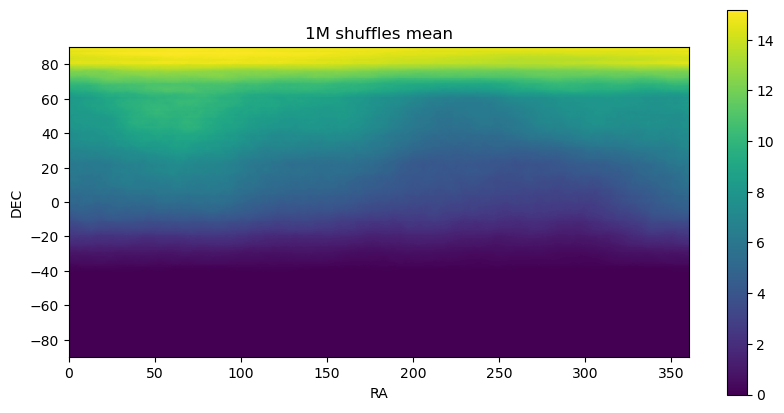

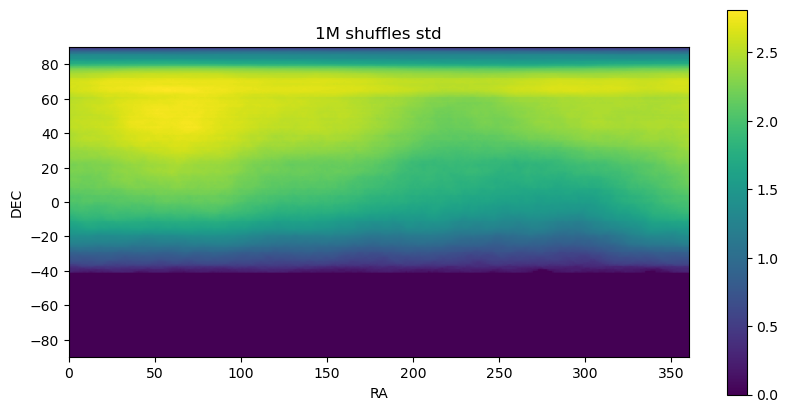

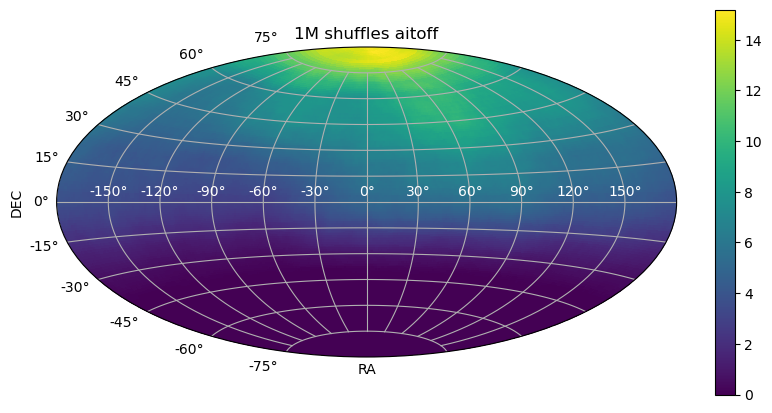

In [7]:
colorplot(averageZ, "1M shuffles mean")
colorplot(sigmaZ, "1M shuffles std")
aitoffcolorplot(averageZ, "1M shuffles aitoff")

# 